In [ ]:
!pip install transformers[torch] datasets evaluate
!pip install -U pip
!pip install cleanvision
!pip install -U albumentations opencv-python
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
    

Подключаем диск

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Импортируем библиотеки

In [ ]:
import tarfile
import pandas as pd
from datasets import load_dataset
import evaluate
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch.nn as nn

# from cleanvision import Imagelab

Подгружаем данные

In [ ]:
# !wget https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar
!cp /content/drive/MyDrive/data/256_ObjectCategories.tar .

file = tarfile.open("256_ObjectCategories.tar")
file.extractall()
file.close()

Создаем датасет(https://huggingface.co/docs/datasets/image_dataset) и сразу же разбиваем его на обучающую и валидационную части

In [ ]:
dataset = load_dataset("imagefolder", data_dir="256_ObjectCategories", split="train").train_test_split(test_size=0.2)

Resolving data files:   0%|          | 0/30608 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 24485
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 6122
    })
})

In [ ]:
dataset["train"][70]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200>,
 'label': 217}

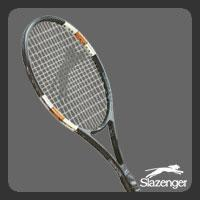

In [ ]:
dataset["train"][70]["image"]

Словари с классами и их id

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label[str(79)]

'080.frog'

Загрузим обрабочик изображений для модели, которую хотим использовать

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "facebook/convnext-tiny-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Преобразования

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])


def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

Применим их к имеющемуся датасету

In [ ]:
dataset = dataset.with_transform(transforms)

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Обучение модели

Загрузим веса выбранной модели(Число выходов финального слоя устанавливаются автоматически)

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True
)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([257, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([257]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


At this point, only three steps remain:

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). It is important you don't remove unused columns because that'll drop the `image` column. Without the `image` column, you can't create `pixel_values`. Set `remove_unused_columns=False` to prevent this behavior! The only other required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the accuracy and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [ ]:
training_args = TrainingArguments(
    output_dir="my_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.192000,1.254818,0.726560
2,0.778400,0.898328,0.784221
3,0.528700,0.796488,0.804639
4,0.354600,0.734036,0.818523
5,0.282200,0.667130,0.838451


TrainOutput(global_step=1915, training_loss=1.045855370887577, metrics={'train_runtime': 2355.1738, 'train_samples_per_second': 51.981, 'train_steps_per_second': 0.813, 'total_flos': 3.0979334270513664e+18, 'train_loss': 1.045855370887577, 'epoch': 5.0})

In [ ]:
# https://huggingface.co/docs/transformers/tasks/image_classification
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/pytorch/image_classification.ipynb#scrollTo=wijQt_1FM9p7

# https://huggingface.co/blog/fine-tune-vit

# https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb

# https://habr.com/ru/articles/704592/